# Polyps segmentation on Colonoscopy Images

__Author: Fernandez Hernandez, Alberto__

__Date: 2022-02-18__

## Data available:
1. CVC-Clinic DB: 612 sequential WL images with polyps extracted from 31 sequences with 31 different polyps

2. ETIS-Larib: 196 WL images with polyps extracted from 34 sequences with 44 different polyps

 | Dataset name | Resolution |
 |--------------|------------|
 | CVC-ClinicDB | 388x324    |
 | ETIS-Larib   | 1225x966   |

In [ ]:
# Updating albumentation library + Install pretrained UNet seg. library
!pip install --upgrade albumentations
!pip install segmentation-models-pytorch
!pip install opencv-python-headless==4.5.2.52

In [2]:
# -- Libraries
from   tqdm                        import tqdm # -- Progress bar
import segmentation_models_pytorch as smp      # -- Pretrained UNet seg. models
import matplotlib.pyplot           as plt      # -- Graphics library
import albumentations              as album    # -- Image augmentation library
import pandas                      as pd       # -- Data manipulation
import numpy                       as np       # -- Numeric operations
import tifffile                    as tiff     # -- Tiff read images library
import torch.nn                    as nn       # -- Deep learning library (I)
import torch                                   # -- Deep learning library (II)
import warnings                                # -- Clear all warning messages
import glob                                    # -- Filesystem access (I) 
import cv2                                     # -- Computer vision library 
import os                                      # -- Filesystem access (II) 

warnings.filterwarnings("ignore")

In [3]:
# -- Constants
TRAIN_DIR        = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/Kvasir-SEG/'
VAL_DIR          = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/ETIS-LaribPolypDB/'
TEST_DIR         = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/CVC-ClinicDB/'
MODEL_PATH       = '/content/drive/MyDrive/Personal/Polyps_Segmentation/models/unet_polyps_seg_model.pth'
ENCODER          = 'resnet18'
ENCODER_WEIGHTS  = 'imagenet'
ACTIVATION       = 'sigmoid'
CLASS_NAMES      = ['polyp', 'background']
CLASS_RGB_VALUES = [[255, 255, 255], [0, 0, 0]]
EPOCHS           = 15
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_CLASS_IND = [CLASS_NAMES.index(cls.lower()) for cls in CLASS_NAMES]
SELECT_CLASS_RGB =  np.array(CLASS_RGB_VALUES)[SELECT_CLASS_IND]

## Define Data Loader class

### Aditional functions

In [4]:
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x
  
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class EndoscopyDataset(torch.utils.data.Dataset):
    """Kvasir-SEG Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            path,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = os.listdir(path + 'images')
        self.mask_paths  = os.listdir(path + 'masks')
        self.path        = path
        self.image_paths.sort()
        self.mask_paths.sort()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation     = augmentation
        self.preprocessing    = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        if '.tif' not in self.image_paths[i]:
          image = cv2.cvtColor(cv2.imread(self.path + 'images/' + self.image_paths[i]), 
                               cv2.COLOR_BGR2RGB)
          mask  = cv2.cvtColor(cv2.imread(self.path + 'masks/' + self.mask_paths[i]), 
                               cv2.COLOR_BGR2RGB)
        else:
          image = tiff.imread(self.path + 'images/' + self.image_paths[i])
          mask  = tiff.imread(self.path + 'masks/' + self.mask_paths[i])
          mask  = np.stack((mask,)*3, axis=-1)
          
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

### Train dir example (Kvasir dataset)

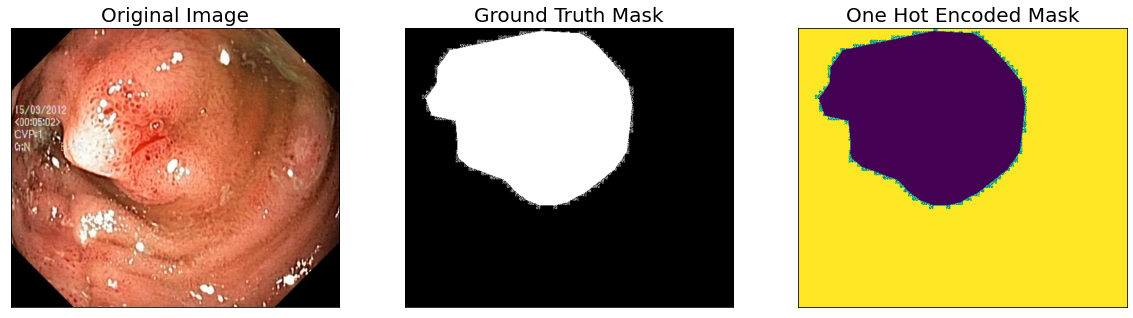

In [6]:
dataset     = EndoscopyDataset(TRAIN_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Val dir example (ETIS-LaribPolypDB dataset)

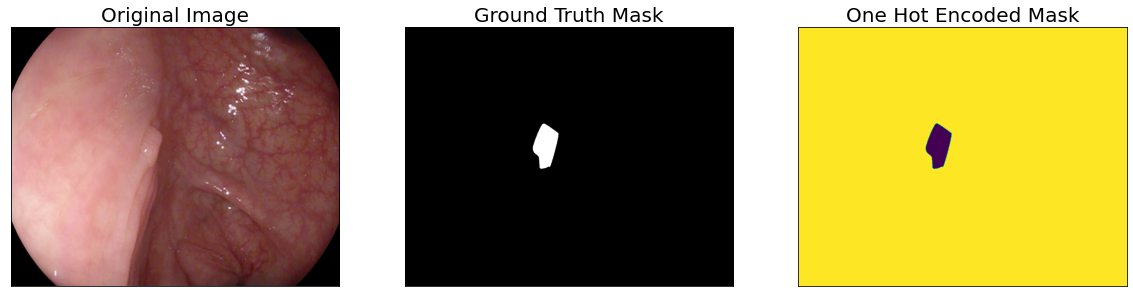

In [7]:
dataset     = EndoscopyDataset(VAL_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Test dir example (CVC-ClinicDB dataset)

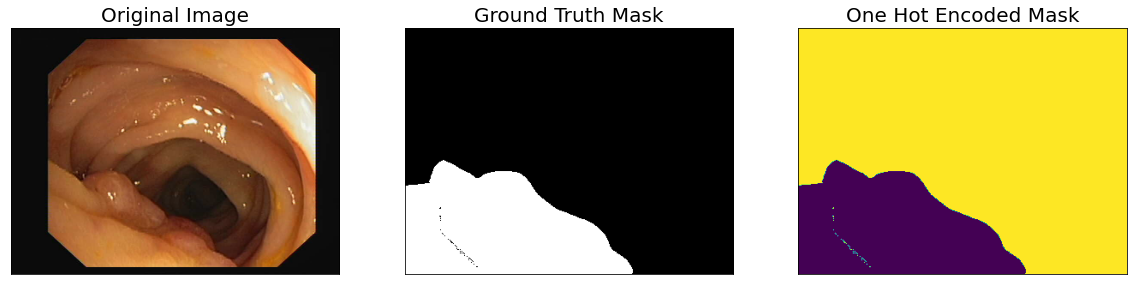

In [8]:
dataset     = EndoscopyDataset(TEST_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

## Data augmentation definition

In [9]:
def get_training_augmentation():
    train_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_test_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

## UNet model definition

![UNet model architecture](https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [11]:
# -- Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASS_NAMES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Define train and validation loaders

In [19]:
# Get train, val and test dataset instances
train_dataset = EndoscopyDataset(
    TRAIN_DIR, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

valid_dataset = EndoscopyDataset(
    VAL_DIR, 
    augmentation=get_validation_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

test_dataset = EndoscopyDataset(
    TEST_DIR, 
    augmentation=get_validation_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

# Get train and val data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Setup hyperparameters

![Intersection over union metric (IoU)](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

In [13]:
# -- Loss function
loss = smp.utils.losses.DiceLoss()

# -- IoU metric (Intersection over Union)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# -- Optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-04),
])

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(MODEL_PATH):
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    print("Model loaded!")

Model loaded!


In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Train model

In [16]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):
    # -- Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # -- Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        torch.save(model, MODEL_PATH)
        print('Saving model...')


Epoch: 0
valid: 100%|██████████| 13/13 [01:06<00:00,  5.12s/it, dice_loss - 0.41, iou_score - 0.8228]
Saving model...

Epoch: 1
valid: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it, dice_loss - 0.308, iou_score - 0.9103]
Saving model...

Epoch: 2
valid: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it, dice_loss - 0.2494, iou_score - 0.9223]
Saving model...

Epoch: 3
valid: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it, dice_loss - 0.2068, iou_score - 0.9268]
Saving model...

Epoch: 4
valid: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it, dice_loss - 0.166, iou_score - 0.9437]
Saving model...

Epoch: 5
valid: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it, dice_loss - 0.1398, iou_score - 0.9504]
Saving model...

Epoch: 6
valid: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it, dice_loss - 0.1228, iou_score - 0.948]

Epoch: 7
valid: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it, dice_loss - 0.09952, iou_score - 0.9543]
Saving model...

Epoch: 8
valid: 100%|██████████| 13/13 [00:28<00:00

In [15]:
# -- Clean cache
torch.cuda.empty_cache()

# Test phase

In [16]:
model = torch.load(MODEL_PATH)

In [20]:
# -- Perform testing
valid_logs = valid_epoch.run(test_loader)
# -- Save model if a better val IoU score is obtained
print("iou_score: " + str(valid_logs['iou_score']))

valid: 100%|██████████| 39/39 [01:43<00:00,  2.64s/it, dice_loss - 0.06506, iou_score - 0.9244]
iou_score: 0.9244127808473046


### Prediction samples + Heatmap

In [50]:
image_vis.shape

(3, 512, 608)

Image #0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


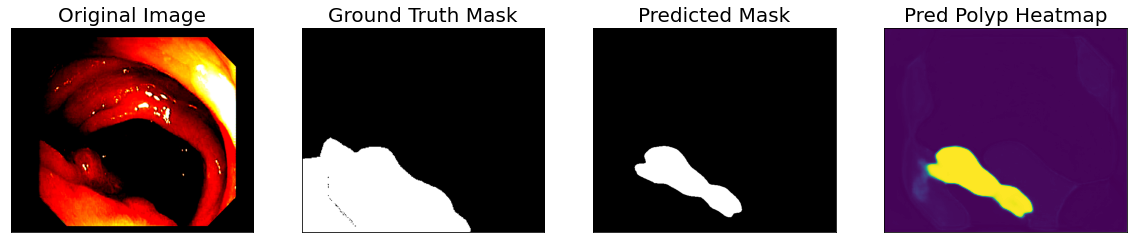

Image #1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


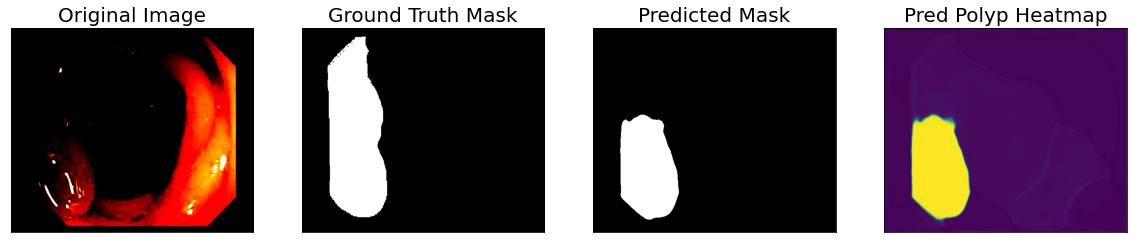

Image #2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


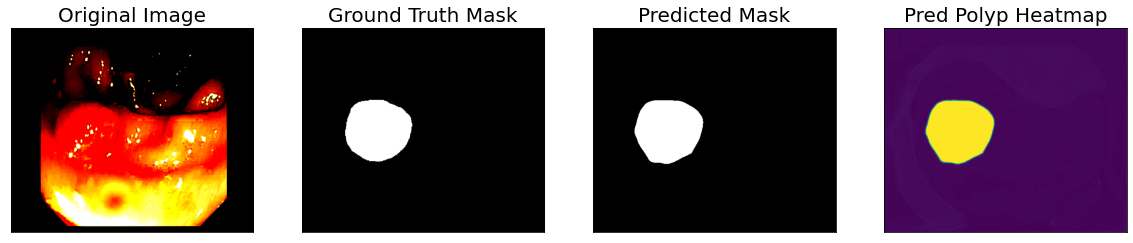

Image #3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


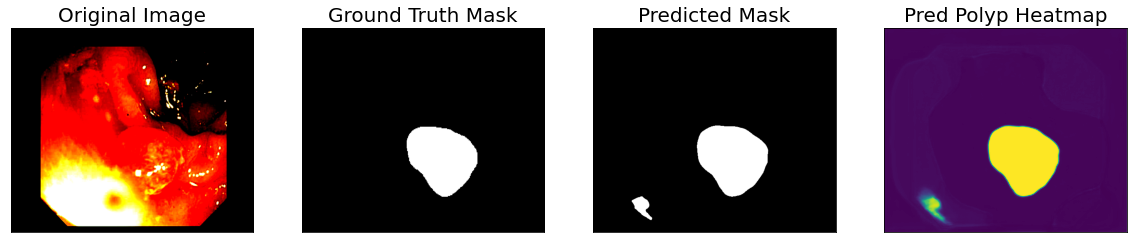

Image #4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


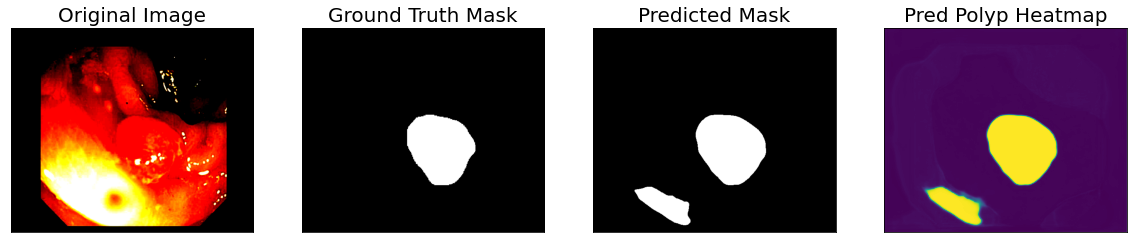

Image #5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


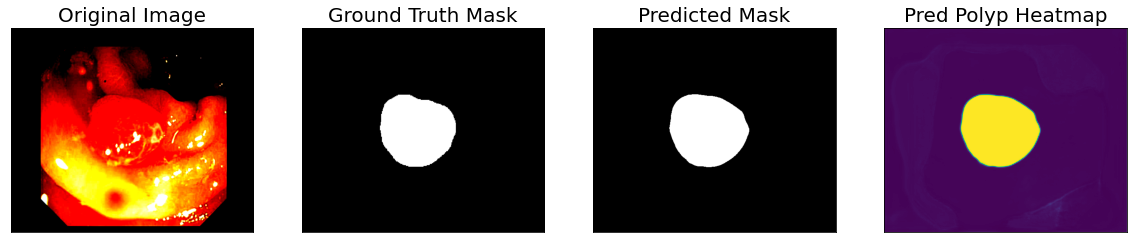

Image #6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


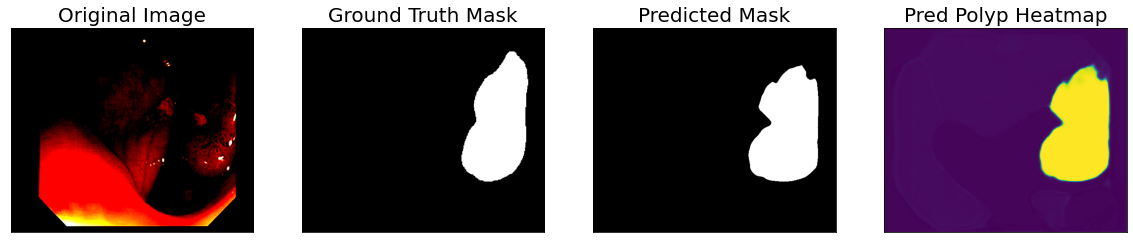

Image #7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


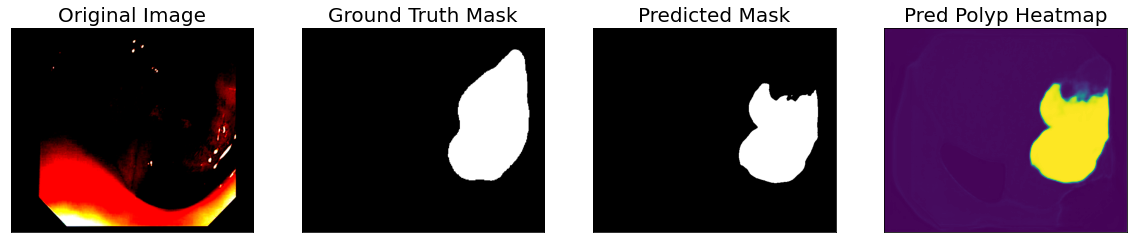

Image #8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


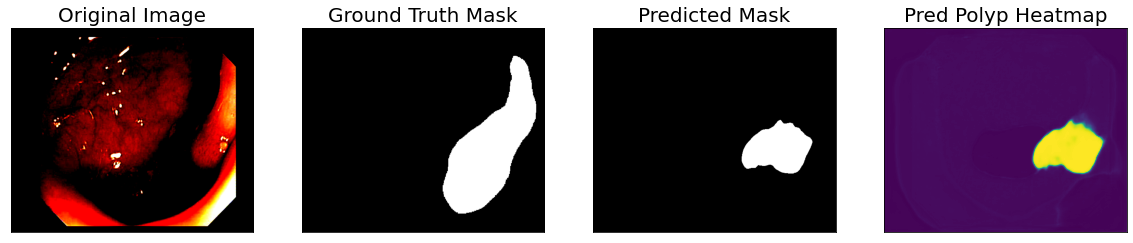

Image #9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


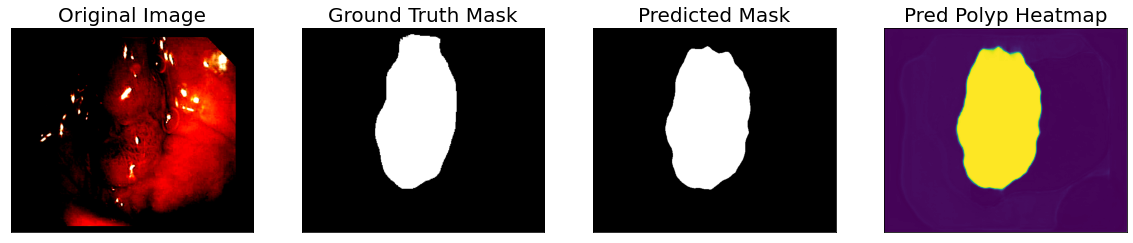

In [66]:
for idx in range(len(test_dataset)):
    if idx < 10:
      print("Image #{}".format(idx))
      image, gt_mask = test_dataset[idx]
      image_vis      = test_dataset[idx][0].astype('uint8')

      input_tensor   = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(input_tensor)
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      # Convert pred_mask from `CHW` format to `HWC` format
      pred_mask = np.transpose(pred_mask,(1,2,0))
      # Get prediction channel corresponding to foreground
      pred_polyp_heatmap = pred_mask[:,:,0]
      pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), CLASS_RGB_VALUES)
      # Convert gt_mask from `CHW` format to `HWC` format
      gt_mask = np.transpose(gt_mask,(1,2,0))
      gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), CLASS_RGB_VALUES)
      
      visualize(
          original_image = np.moveaxis(image, 0, -1),
          ground_truth_mask = gt_mask,
          predicted_mask = pred_mask,
          pred_polyp_heatmap = pred_polyp_heatmap
      )